# Sequentially Comparing Statistical Postprocessing Methods for Weather Forecasts

Following [Henzi and Ziegel (2021)](https://arxiv.org/abs/2103.08402), we compare pairs of [statistical postprocessing](https://arxiv.org/abs/2004.06582) methods for weather forecasts, namely IDR, HCLR, and HCLR_ (HCLR sans a scale parameter).

We use both confidence sequences and e-processes for this analysis.

Code/Data References:
- https://github.com/AlexanderHenzi/eprob/tree/master/replication_material
- https://github.com/AlexanderHenzi/isodistrreg

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path

import comparecast as cc

In [2]:
DATA_DIR = "eprob/replication_material/precip_fcs"
PLOTS_DIR = "plots/weather"

In [3]:
cc.set_theme()

In [4]:
ALPHA = 0.1  # significance level; roughly corresponds to E > 1/0.05 = 20 for each side
V_OPT = 0.5  # optimized intrinsic time
C = 0.001    # aggressiveness of the "bet" for the e-process

## Data & Forecasts

_See [`nb_comparecast_weather_eda.ipynb`](./nb_comparecast_weather_eda.ipynb) for data exploration plots._


- The dataset is collected by Henzi et al. (2019), containing 24-hour accumulated precipitation (mm, integer-rounded) from 2007-01-06 to 2017-01-01 at meteorological stations on airports in London, Brussels, Zurich, and Frankfurt. 
- Covariates (initial forecasts) are the 52 members (1 high-resolution `hres` member, 1 control `ctr` member, and 50 perturbed members that are ensembled `ens`) of the NWP ensemble operated by the European Centre for Medium-Range Weather Forecasts (ECMWF; Molteni et al., 1996; Buizza et al., 2005) for days 1 to 5.
- We compare IDR, HCLR, and HCLR_ as three statistical postprocessing methods for predicting the [probability of precipitation (PoP)](https://www.weather.gov/ffc/pop) given these covariates. Each postprocessing method is fit to the first half of the dataset; we compare their performances on the second half for validation.

## Comparison with Henzi & Ziegel's Results in the Lag-1 Case

### Henzi & Ziegel (2021)


Henzi & Ziegel's e-values measure evidence against the null that the score differentials are $\leq 0$ _for all timesteps $t$_.

$$
H_0: \mathbb{E}_P[S(p_t, y_t) - S(q_t, y_t) \mid \mathcal{F}_{t-1}] \leq 0 \quad \forall t
$$

In [5]:
evalues_hz = cc.data_utils.weather.read_hz_evalues(os.path.join(DATA_DIR, "evalues.csv"))
evalues_hz

,Airport,Lag,Date,Precipitation,HCLR,HCLR_,IDR,PoP,Hypothesis,E-value
125,Brussels,1,2012-02-03,0.0,0.071857,0.140121,0.00926,0.0,HCLR/IDR,0.983689
32920,Brussels,1,2012-02-03,0.0,0.071857,0.140121,0.00926,0.0,IDR/HCLR_,1.035356
65715,Brussels,1,2012-02-03,0.0,0.071857,0.140121,0.00926,0.0,HCLR/HCLR_,1.019089
135,Brussels,1,2012-02-04,1.2,0.760288,0.689796,0.61111,1.0,HCLR/IDR,1.037191
32930,Brussels,1,2012-02-04,1.2,0.760288,0.689796,0.61111,1.0,IDR/HCLR_,1.004044
...,...,...,...,...,...,...,...,...,...,...
65569,Zurich,5,2016-12-31,0.0,0.071938,0.152498,0.10734,0.0,IDR/HCLR_,0.000017
98364,Zurich,5,2016-12-31,0.0,0.071938,0.152498,0.10734,0.0,HCLR/HCLR_,39.745275
32794,Zurich,5,2017-01-01,0.0,0.065383,0.146635,0.01538,0.0,HCLR/IDR,4916.184181
65589,Zurich,5,2017-01-01,0.0,0.065383,0.146635,0.01538,0.0,IDR/HCLR_,0.000018


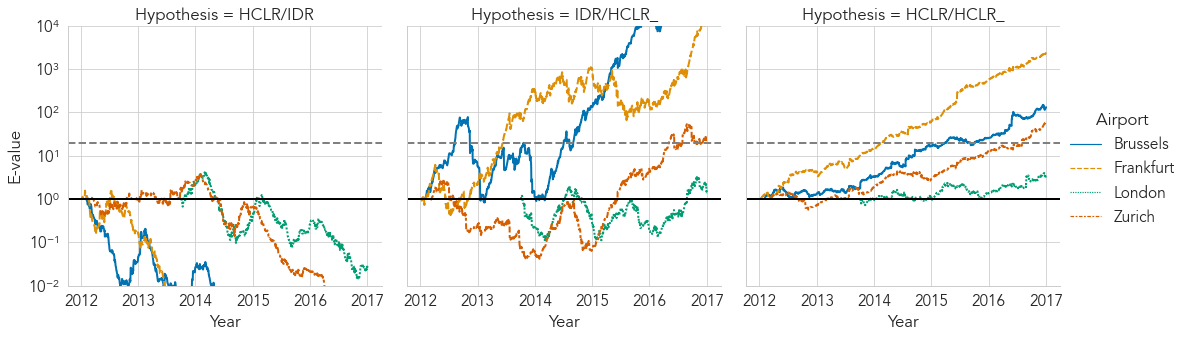

In [6]:
# lag 1 plot (Figure 3, HZ'21)
cc.plot_weather_hz_evalues(
    evalues_hz[evalues_hz["Lag"] == 1],
    save_filename=os.path.join(PLOTS_DIR, "evalues_hz_lag1.pdf"),
    font_scale=1.75,
)

## Ours

Our e-processes measure evidence against the null that the _average_ score differentials _up to time $t$_ are $\leq 0$. This is an example of a "weak null" and would be more difficult to reject than Henzi & Ziegel's "strong null".

$$
H_0 : \frac{1}{t}\sum_{i=1}^t \mathbb{E}_P[S(p_i, y_i) - S(q_i, y_i) \mid \mathcal{F}_{i-1}] \leq 0 \quad \forall t
$$

We compute both a 90% confidence sequence and a corresponding e-value.

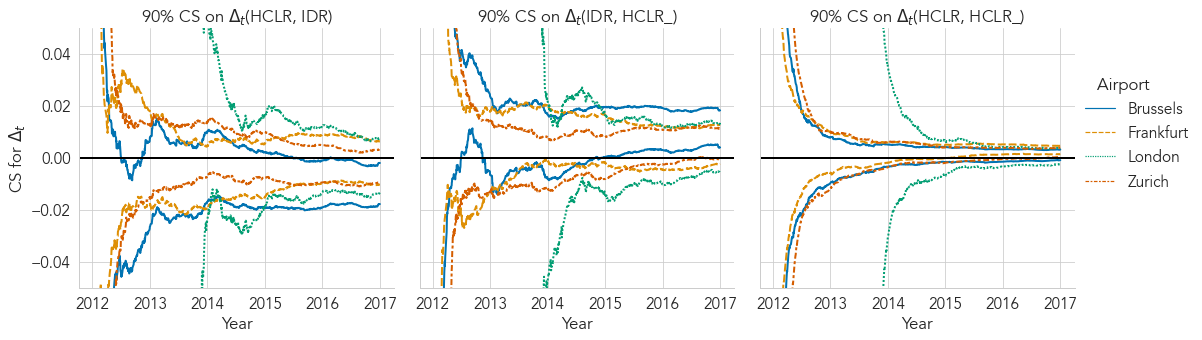

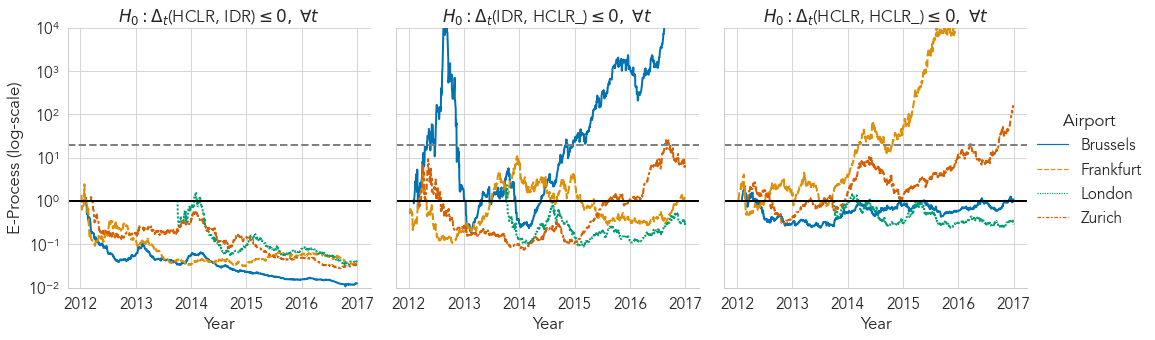

In [7]:
results = cc.plot_weather_comparison(
    data_dir=DATA_DIR,
    lag=1,
    scoring_rule="brier",
    alpha=ALPHA,
    v_opt=V_OPT,
    c=C,
    plots_dir=PLOTS_DIR,
    # use_preset_theme=False,
    font_scale=1.75,
)

## Fixed-Sample Comparisons

Print comparisons in which zero is not included in the CS at the final time step, for all datasets (airports X lags).

In [8]:
from comparecast.data_utils.weather import AIRPORTS, LAGS

pop_fcs = cc.data_utils.weather.read_precip_fcs(DATA_DIR, pop_only=True)

pairs = [("hclr", "idr"), ("idr", "hclr_noscale"), ("hclr", "hclr_noscale")]
print(f"[{100*(1-ALPHA):g}% EB CS at the final time step, decision]")
for airport in AIRPORTS:
    for lag in LAGS:
        pop_fcs_data = pop_fcs[(pop_fcs["airport"] == airport) & 
                               (pop_fcs["lag"] == lag)].copy()
        pop_fcs_data["time"] = np.arange(1, len(pop_fcs_data) + 1)
        for name_p, name_q in pairs:
            results = cc.compare_forecasts(
                pop_fcs_data, 
                name_p, 
                name_q, 
                "brier",
                alpha=ALPHA,
                v_opt=V_OPT,
                c=C,
                compute_e=True,
            )
            lcbs, ucbs = results.lcb.values, results.ucb.values
            if lcbs[-1] > 0:
                decision = name_p
            elif ucbs[-1] < 0:
                decision = name_q
            else:
                decision = None
            if decision is not None:
                print(f"{airport:9}/{lag} [T={len(lcbs)}], "
                      f"{name_p:4} vs {name_q:12}: "
                      f"({lcbs[-1]:8.5f}, {ucbs[-1]:8.5f}) \t{decision}")
            
#             if evalues[-1] > 10:
#                 print(f"{airport:9}/{lag} [T={len(lcbs)}], "
#                       f"{name_p:4} vs {name_q:12}: "
#                       f"E {evalues[-1]:7.3f}")

[90% EB CS at the final time step, decision]
Brussels /1 [T=1703], hclr vs idr         : (-0.01790, -0.00209) 	idr
Brussels /1 [T=1703], idr  vs hclr_noscale: ( 0.00389,  0.01815) 	idr
Brussels /3 [T=1703], hclr vs hclr_noscale: ( 0.00010,  0.00606) 	hclr
Brussels /5 [T=1703], hclr vs idr         : ( 0.00122,  0.01909) 	hclr
Brussels /5 [T=1703], hclr vs hclr_noscale: ( 0.00052,  0.00535) 	hclr
Frankfurt/1 [T=1809], hclr vs hclr_noscale: ( 0.00132,  0.00453) 	hclr
Frankfurt/2 [T=1809], idr  vs hclr_noscale: ( 0.00111,  0.01443) 	idr
Frankfurt/2 [T=1809], hclr vs hclr_noscale: ( 0.00068,  0.00540) 	hclr
Frankfurt/3 [T=1809], idr  vs hclr_noscale: ( 0.00162,  0.01557) 	idr
Frankfurt/3 [T=1809], hclr vs hclr_noscale: ( 0.00176,  0.00698) 	hclr
Frankfurt/4 [T=1809], hclr vs hclr_noscale: ( 0.00081,  0.00538) 	hclr
Zurich   /1 [T=1621], hclr vs hclr_noscale: ( 0.00034,  0.00379) 	hclr
Zurich   /2 [T=1621], hclr vs hclr_noscale: ( 0.00077,  0.00422) 	hclr
Zurich   /3 [T=1621], hclr vs hclr_n

## Lag-$h$ Comparisons

For $h = 1, 2, 3, 4, 5$, we plot the lag-$h$ sequential e-values (Section F) for the weak (`w`) and the period-wise (`pw`) weak nulls.
HZ's sequential e-values for the strong (`s`) null serve as a comparison.
We expect that, in general, $E^{\mathsf{w}} \leq E^{\mathsf{pw}} \leq E^{\mathsf{s}}$.

In [9]:
# how aggressively do we bet?
c = C

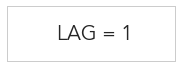

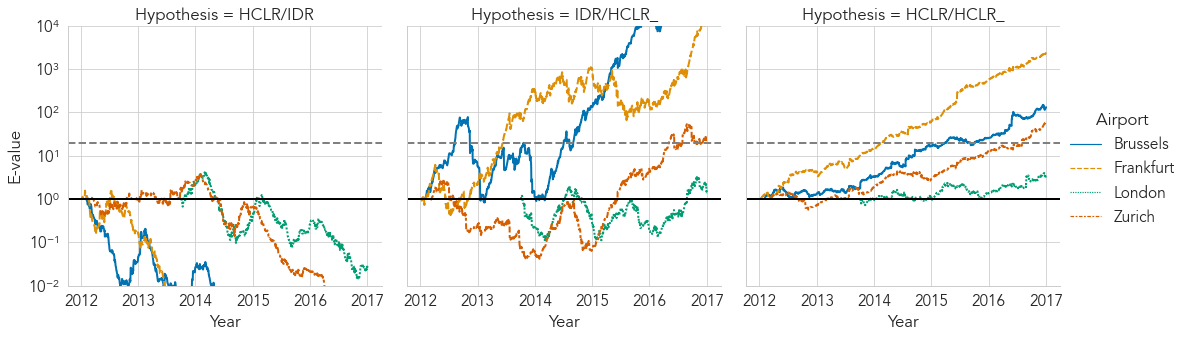

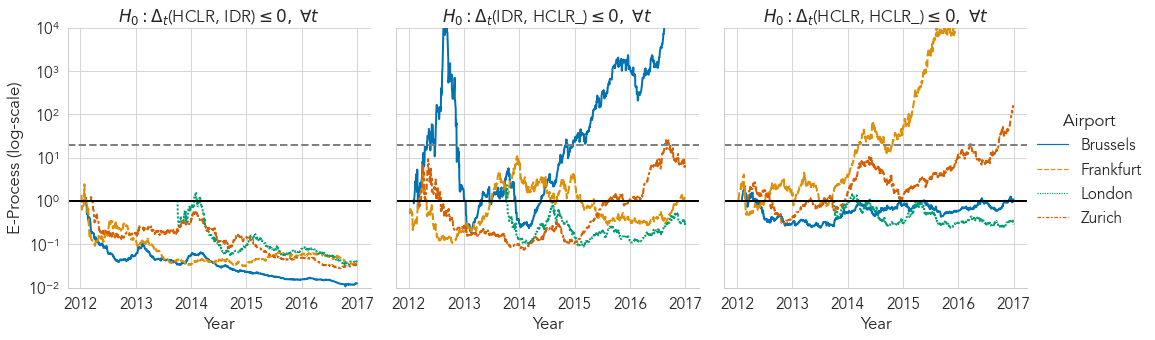

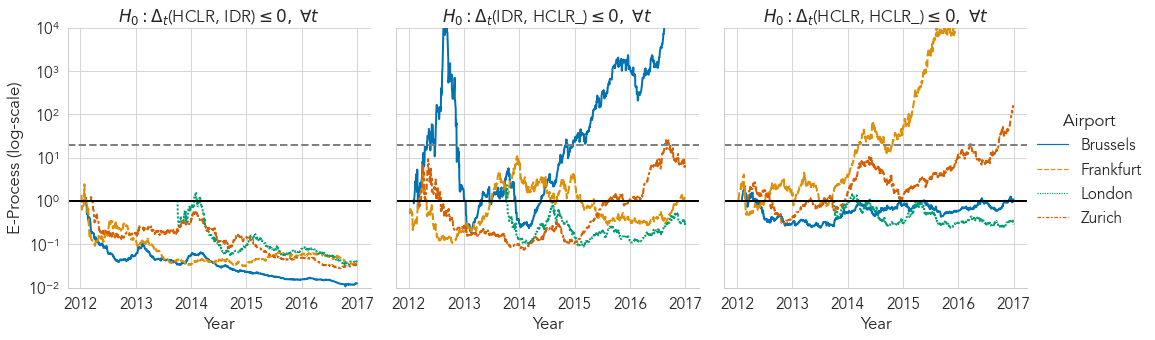

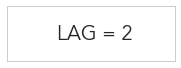

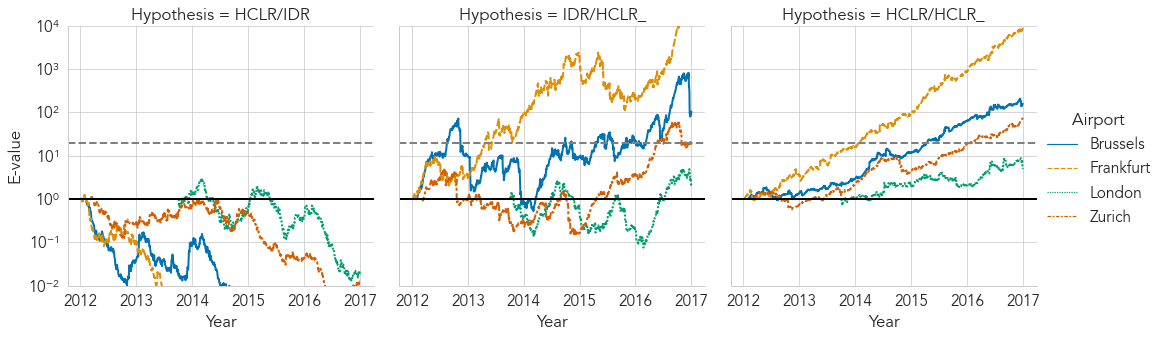

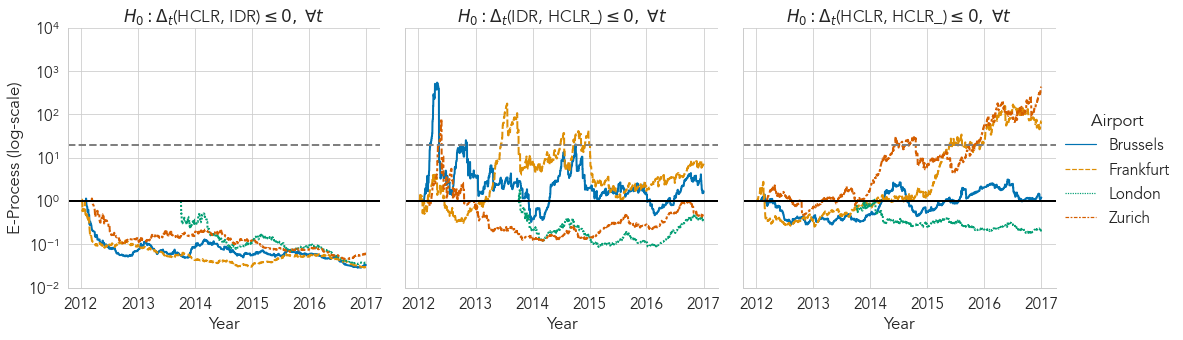

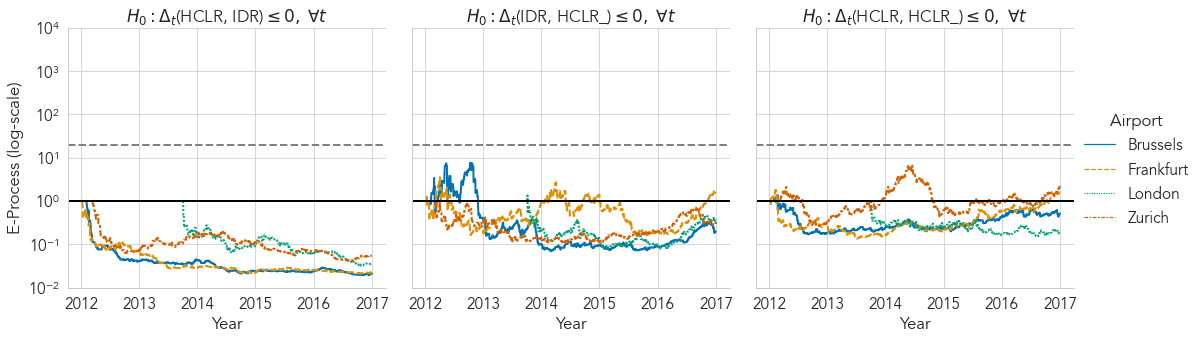

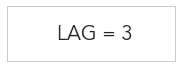

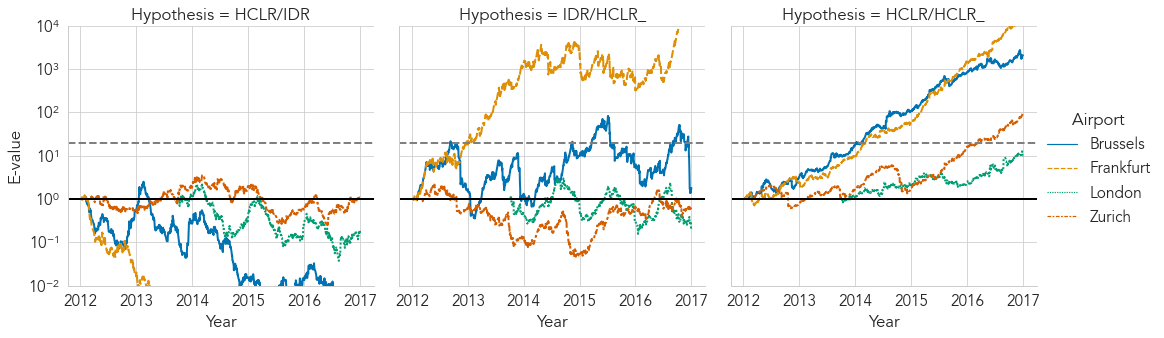

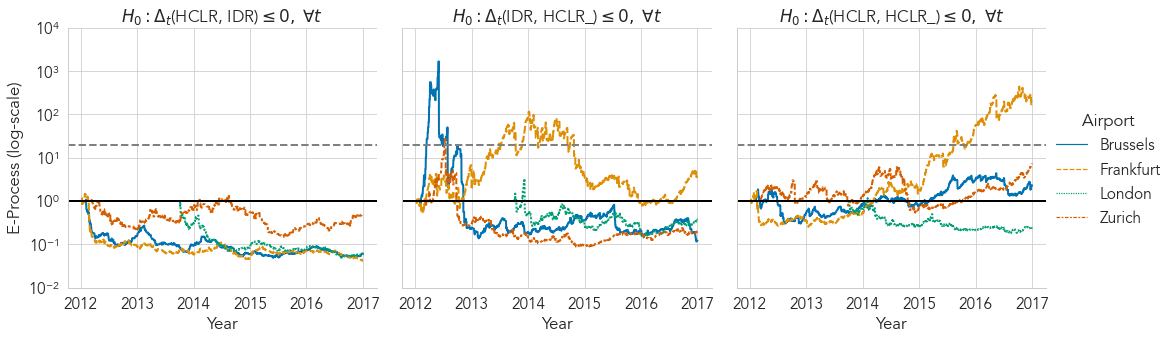

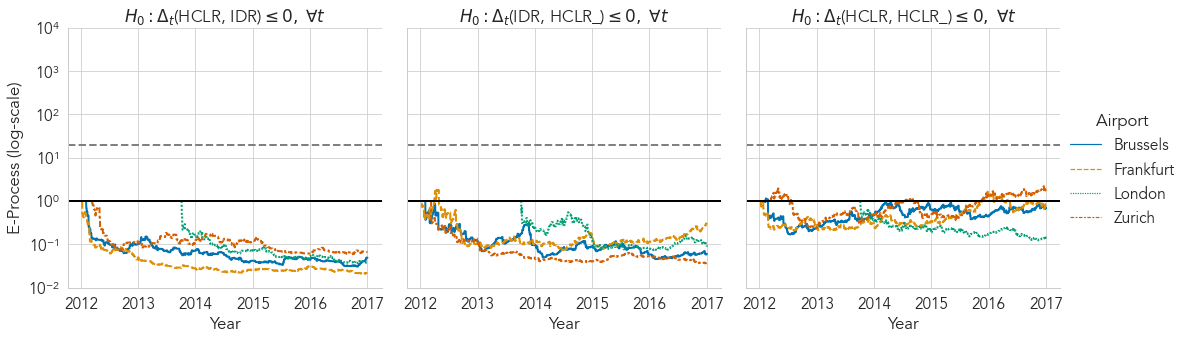

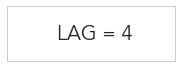

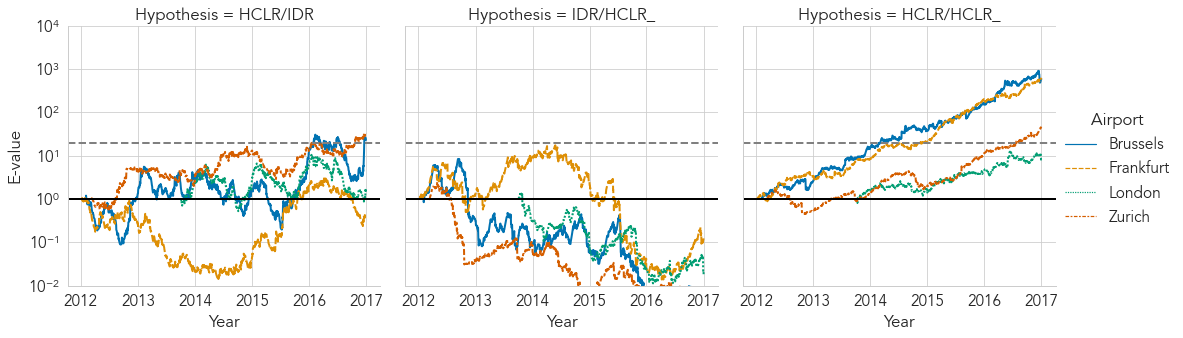

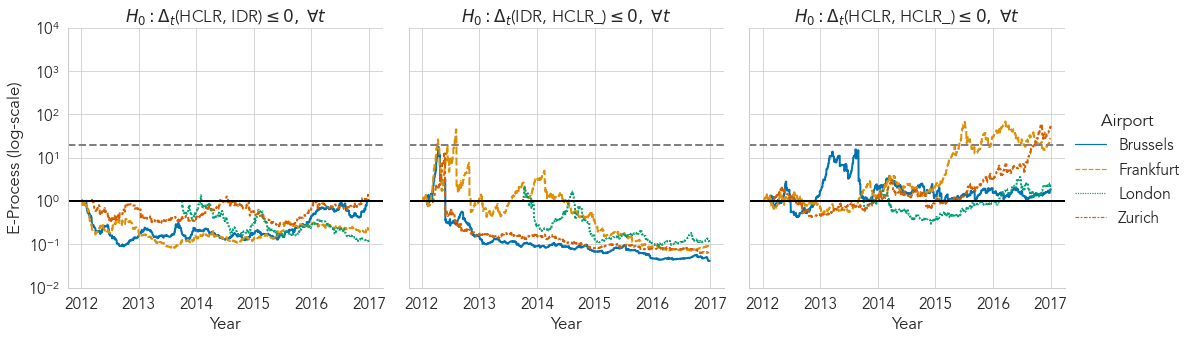

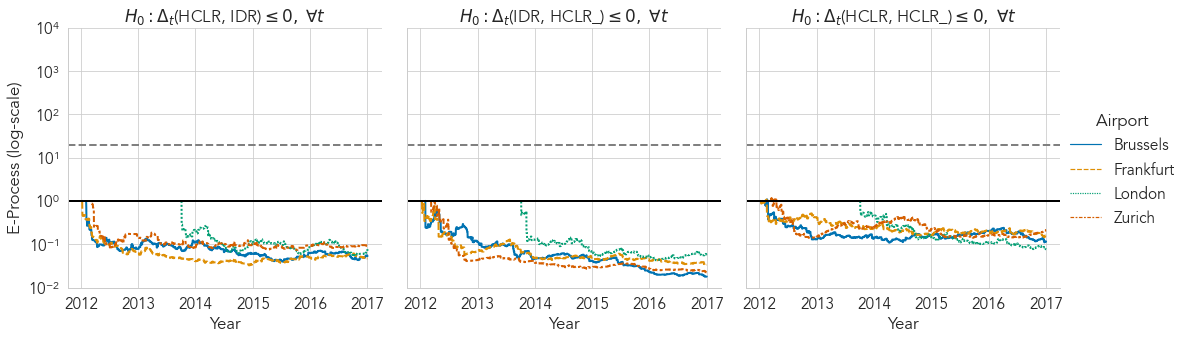

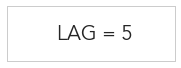

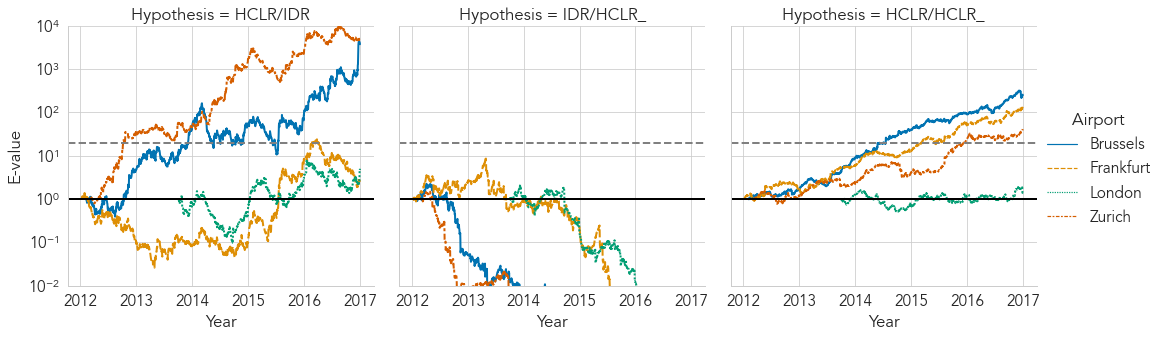

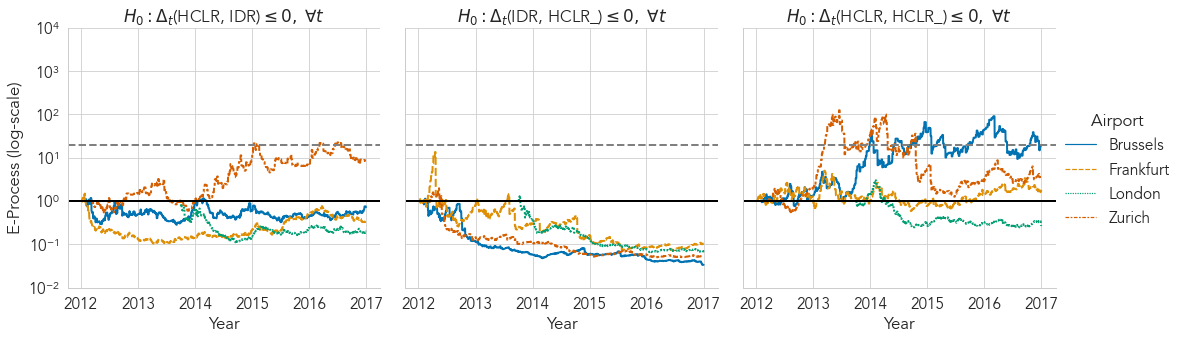

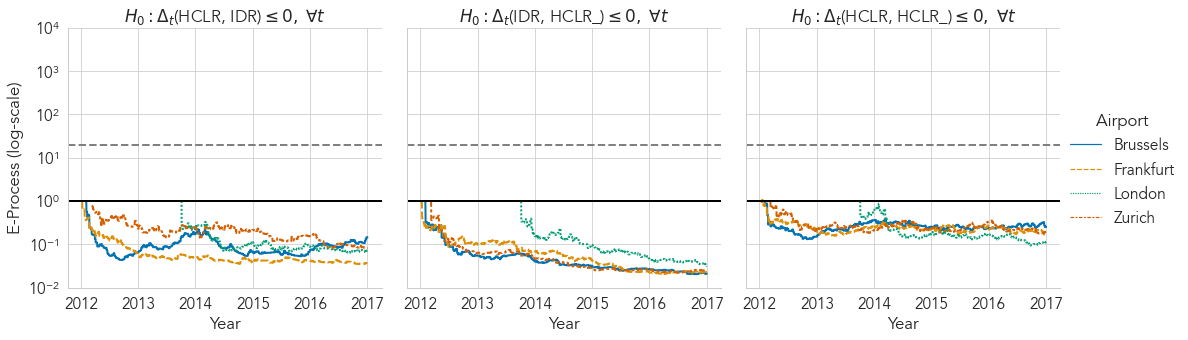

In [10]:
results_pw = []
results_w = []
for lag in [1, 2, 3, 4, 5]:
    plt.figure(figsize=(3, 1))
    plt.text(x=0.3, y=0.4, s=f"LAG = {lag}", fontsize="large")
    plt.xticks([])
    plt.yticks([])
    plt.grid()
    
    # HZ
    cc.plot_weather_hz_evalues(
        evalues_hz[evalues_hz["Lag"] == lag],
        save_filename=os.path.join(PLOTS_DIR, f"evalues_hz_lag{lag}.pdf"),
        font_scale=1.75,
    )
    # Ours, for the period-wise weak null
    result_pw = cc.plot_weather_comparison(
        data_dir=DATA_DIR,
        lag=lag,
        lagged_null="pw",
        scoring_rule="brier",
        alpha=ALPHA,
        v_opt=V_OPT / lag,
        c=c,
        compute_cs=False,
        plots_dir=PLOTS_DIR,
        font_scale=1.75,
        no_calibration=True,
    )
    results_pw.append(result_pw)
    # Ours, for the weak null
    result_w = cc.plot_weather_comparison(
        data_dir=DATA_DIR,
        lag=lag,
        lagged_null="w",
        scoring_rule="brier",
        alpha=ALPHA,
        v_opt=V_OPT / lag,
        c=c,
        compute_cs=False,
        plots_dir=PLOTS_DIR,
        font_scale=1.75,
        no_calibration=True,
    )
    results_w.append(result_w)

In [11]:
results_pw = pd.concat(results_pw)
results_w = pd.concat(results_w)

## Fixed-Sample Comparisons (for $\LaTeX$)

Across all locations.

In [12]:
def latex_print(location, lag, hypo1, hypo2, hypo3):
    """location & lag & hypo1 & hypo2 & hypo3."""
    print("{:12s} & {:4s} & {:17s} & {:17s} & {:17s} \\\\".format(
        location, lag, hypo1, hypo2, hypo3
    ))
    
def format_e(e):
    return "{:7.3f}".format(e) if e <= 100 else r"$>$ 100"

Table for the main text: sequential e-values (no calibration)

In [13]:
# last-day comparisons: e_w (ours), e_pw (ours), e_hz
latex_print("Location", "Lag", "HCLR/IDR", "IDR/HCLR_", "HCLR/HCLR_")
for airport in cc.data_utils.weather.AIRPORTS:
    print("\\hline\t\\multirow{{5}}{{*}}{{{}}}".format(airport))
    for lag in cc.data_utils.weather.LAGS:
        e_w = []
        e_pw = []
        e_hz = []
        for hypothesis in ["HCLR/IDR", "IDR/HCLR_", "HCLR/HCLR_"]:
            query = f"Airport == '{airport}' & Lag == {lag} & Date == '2017-01-01' & Hypothesis == '{hypothesis}'"
            e_w.append(results_w.query(query + " & OutputType == 'E-value'")[["Value"]].values.item())
            e_pw.append(results_pw.query(query + " & OutputType == 'E-value'")[["Value"]].values.item())
            e_hz.append(evalues_hz.query(query)[["E-value"]].values.item())
        latex_print(
            "", 
            str(lag), 
            *["{:7s} & {:7s} & {:7s}".format(*[format_e(e) for e in es]) 
              for es in zip(e_w, e_pw, e_hz)],
        )

Location     & Lag  & HCLR/IDR          & IDR/HCLR_         & HCLR/HCLR_        \\
\hline	\multirow{5}{*}{Brussels}
             & 1    &   0.012 &   0.012 &   0.000 & $>$ 100 & $>$ 100 & $>$ 100 &   1.083 &   1.083 & $>$ 100 \\
             & 2    &   0.021 &   0.033 &   0.000 &   0.196 &   1.659 & $>$ 100 &   0.510 &   1.196 & $>$ 100 \\
             & 3    &   0.049 &   0.060 &   0.006 &   0.060 &   0.121 &   1.786 &   0.698 &   2.289 & $>$ 100 \\
             & 4    &   0.053 &   1.032 &  22.811 &   0.018 &   0.042 &   0.000 &   0.114 &   1.855 & $>$ 100 \\
             & 5    &   0.145 &   0.714 & $>$ 100 &   0.021 &   0.034 &   0.000 &   0.254 &  19.411 & $>$ 100 \\
\hline	\multirow{5}{*}{Frankfurt}
             & 1    &   0.034 &   0.034 &   0.000 &   1.284 &   1.284 & $>$ 100 & $>$ 100 & $>$ 100 & $>$ 100 \\
             & 2    &   0.022 &   0.029 &   0.000 &   1.573 &   7.223 & $>$ 100 &   1.537 &  69.508 & $>$ 100 \\
             & 3    &   0.022 &   0.041 &   0.000 &   0.311